In [5]:
!conda install -c conda-forge gdcm -y

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - rapidsai
 - nvidia
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.7.1               |  py310hff52083_0         940 KB  conda-forge
    gdcm-2.8.9                 | py310h59700c5_10         2.7 MB  conda-forge
    json-c-0.17                |       h1220068_1          82 KB  conda-forge
    openssl-3.3.1              |       h4bc722e_2         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.4 MB

The following NEW packages will be INSTALLED:

  gdcm               conda-forge/linux-64::gdcm-2.8.9-py310h59700c5_10 
  json-c             conda-forge/linux-64::json-c-0.17-h

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom
import scipy.ndimage
import gdcm

import glob

from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.morphology import disk, opening, closing
from tqdm import tqdm

from IPython.display import HTML
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from os import listdir, mkdir

In [7]:
basepath = "/kaggle/input/rsna-str-pulmonary-embolism-detection/"

In [9]:
train = pd.read_csv("/kaggle/input/df-filtered-after-eda/final_df_Pulmonary_Embolism_CT_scans_data.csv")
test = pd.read_csv(basepath + "test.csv")

In [10]:
train["dcm_path"] = basepath + "train/" + train.StudyInstanceUID + "/" + train.SeriesInstanceUID

In [11]:
def load_scans(dcm_path):
    # We sort by ImagePositionPatient (z-coordinate) or by SliceLocation    
    slices = [pydicom.dcmread(dcm_path + "/" + file) for file in listdir(dcm_path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

In [12]:
example = train.dcm_path.values[0]
scans = load_scans(example)

In [13]:
example

'/kaggle/input/rsna-str-pulmonary-embolism-detection/train/6897fa9de148/2bfbb7fd2e8b'

In [15]:
scans[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 172
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.405991.10080
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI DUAL', 'STD', 'SNRG', 'DET_AB']
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: baedb900c69c
(0008, 0060) Modality                            CS: 'CT'
(0018, 0

In [16]:
def set_outside_scanner_to_air(raw_pixelarrays):
    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    images = set_outside_scanner_to_air(images)
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)


hu_scans = transform_to_hu(scans)

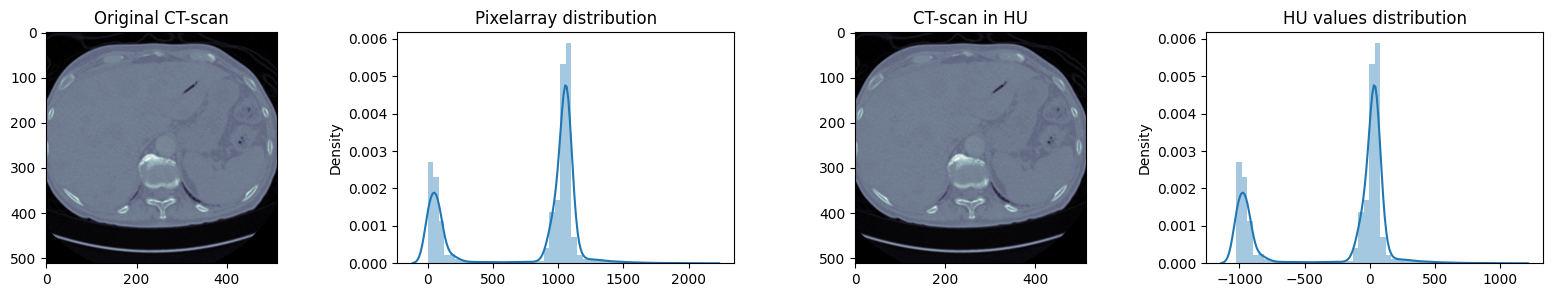

In [17]:
fig, ax = plt.subplots(1,4,figsize=(20,3))
ax[0].set_title("Original CT-scan")
ax[0].imshow(scans[0].pixel_array, cmap="bone")
ax[1].set_title("Pixelarray distribution");
sns.distplot(scans[0].pixel_array.flatten(), ax=ax[1]);

ax[2].set_title("CT-scan in HU")
ax[2].imshow(hu_scans[0], cmap="bone")
ax[3].set_title("HU values distribution");
sns.distplot(hu_scans[0].flatten(), ax=ax[3]);

for m in [0,2]:
    ax[m].grid(False)

📌 Now all raw values per slice are scaled to H-units.

### Voxel Size Normalization

The voxel stands for the 3D-pixel that is given in a CT-scan. As far as I know it is spanned by the 2d-plane of the pixelspacing attribute in x- and y-direction and the slice thickness in z-direction.


**Pixelspacing**

The pixelspacing attribute you can find in the dicom files is an important one. It tells us how much physical distance is covered by one pixel. You can see that there are only 2 values that describe the x- and y-direction in the plane of a transversal slice.

For one patient this pixelspacing is usually the same for all slices.


But between patients the pixelspacing can differ due to personal or institutional preferences of doctors and the clinic and it also depends on the scanner type. Consequently if you compare two images in the size of the lungs it does not automatically mean that the bigger one is really larger in the physical size of the organ!


Let's explore the distributions of the patients pixelspacing widths and heights of this competition:

In [21]:
N = 1000
def get_window_value(feature):
    if isinstance(feature, pydicom.multival.MultiValue):
        return int(feature[0])
    else:
        return int(feature)

pixelspacing_r = []
pixelspacing_c = []
slice_thicknesses = []
patient_id = []
patient_pth = []
row_values = []
column_values = []
window_widths = []
window_levels = []

if basepath == "../input/osic-pulmonary-fibrosis-progression/":
    patients = train.Patient.unique()[0:N]
else:
    patients = train.SeriesInstanceUID.unique()[0:N]

for patient in patients:
    patient_id.append(patient)
    if basepath == "../input/osic-pulmonary-fibrosis-progression/":
        path = train[train.Patient == patient].dcm_path.values[0]
    else:
        path = train[train.SeriesInstanceUID == patient].dcm_path.values[0]
    example_dcm = listdir(path)[0]
    patient_pth.append(path)
    dataset = pydicom.dcmread(path + "/" + example_dcm)
    
    window_widths.append(get_window_value(dataset.WindowWidth))
    window_levels.append(get_window_value(dataset.WindowCenter))
    
    spacing = dataset.PixelSpacing
    slice_thicknesses.append(dataset.SliceThickness)
    
    row_values.append(dataset.Rows)
    column_values.append(dataset.Columns)
    pixelspacing_r.append(spacing[0])
    pixelspacing_c.append(spacing[1])
    
scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
scan_properties.loc[:, "rows"] = row_values
scan_properties.loc[:, "columns"] = column_values
scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
scan_properties.loc[:, "patient_pth"] = patient_pth
scan_properties.loc[:, "window_width"] = window_widths
scan_properties.loc[:, "window_level"] = window_levels
scan_properties.head()

,patient,rows,columns,area,pixelspacing_r,pixelspacing_c,pixelspacing_area,slice_thickness,patient_pth,window_width,window_level
0,2bfbb7fd2e8b,512,512,262144,0.523438,0.523438,0.273987,2.0,/kaggle/input/rsna-str-pulmonary-embolism-dete...,400,40
1,2805267980e7,512,512,262144,0.580078,0.580078,0.336491,2.0,/kaggle/input/rsna-str-pulmonary-embolism-dete...,350,50
2,bac7becd2970,512,512,262144,0.615234,0.615234,0.378513,2.0,/kaggle/input/rsna-str-pulmonary-embolism-dete...,400,40
3,7d17c72fd0ce,512,512,262144,0.648438,0.648438,0.420471,3.0,/kaggle/input/rsna-str-pulmonary-embolism-dete...,400,40
4,80e33d285534,512,512,262144,0.726562,0.726562,0.527893,3.0,/kaggle/input/rsna-str-pulmonary-embolism-dete...,390,65


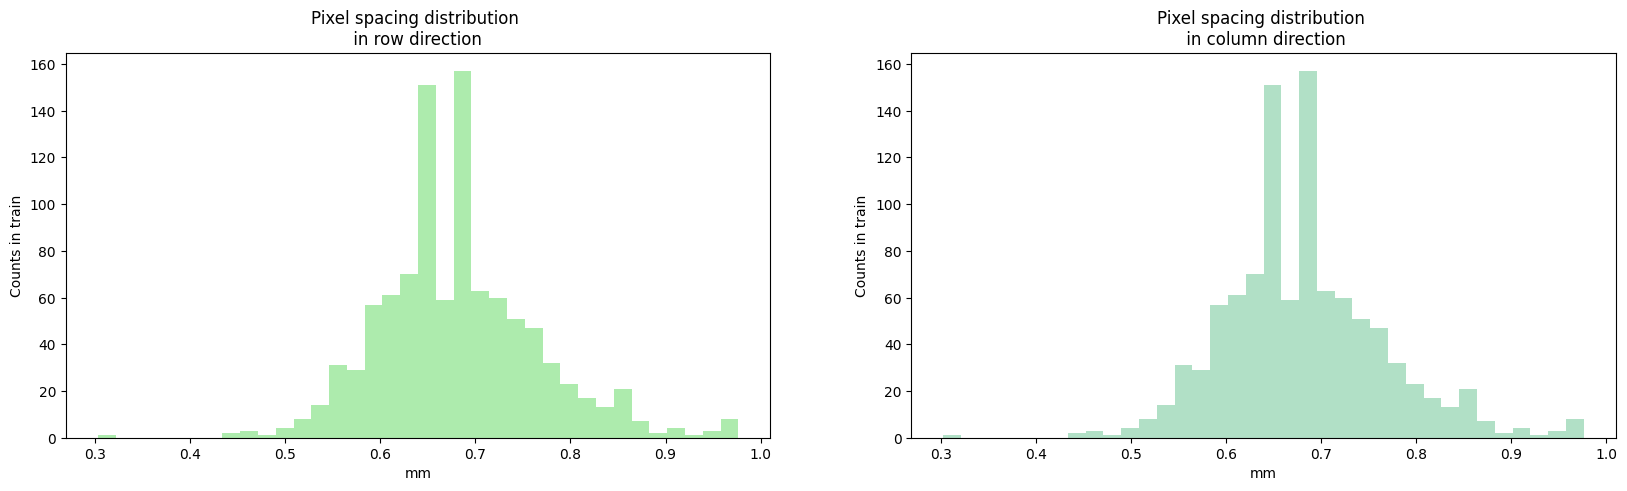

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(pixelspacing_r, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing distribution \n in row direction ")
ax[0].set_ylabel("Counts in train")
ax[0].set_xlabel("mm")
sns.distplot(pixelspacing_c, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing distribution \n in column direction");
ax[1].set_ylabel("Counts in train");
ax[1].set_xlabel("mm");

📌 We can see that the values really vary a lot from patient to patient! As they are given in mm and ct-scans usually cover 512 row and column values... We need to check this! 

We can compute the minimum and maximum distance that is covered by the images:

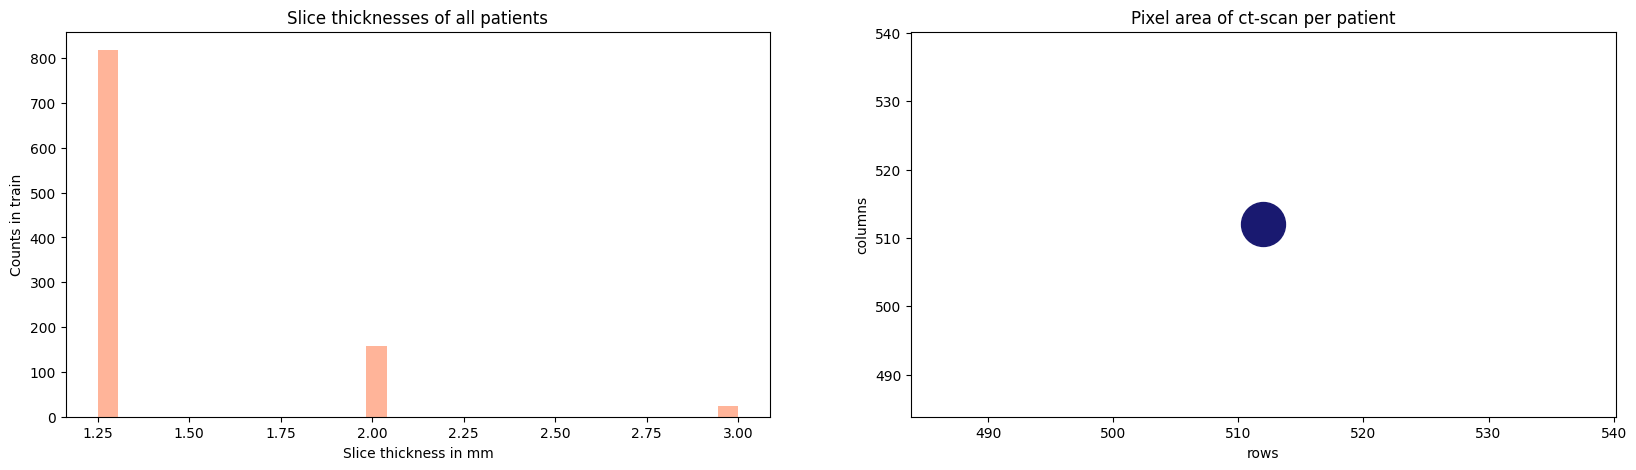

In [23]:
counts = scan_properties.groupby(["rows", "columns"]).size()
counts = counts.unstack()
counts.fillna(0, inplace=True)


fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(slice_thicknesses, color="orangered", kde=False, ax=ax[0])
ax[0].set_title("Slice thicknesses of all patients");
ax[0].set_xlabel("Slice thickness in mm")
ax[0].set_ylabel("Counts in train");

for n in counts.index.values:
    for m in counts.columns.values:
        ax[1].scatter(n, m, s=counts.loc[n,m], c="midnightblue")
ax[1].set_xlabel("rows")
ax[1].set_ylabel("columns")
ax[1].set_title("Pixel area of ct-scan per patient");

📌 Very thin slices allow more details to be shown. On the other hand thick slices contain less noise but are more prone to artifacts. Hmm... I'm very excited to see some examples here as well.

📌 Proper preprocessing of these scans might be very important... we have to check it.


### Physical area & slice volume covered by a single ct-scan

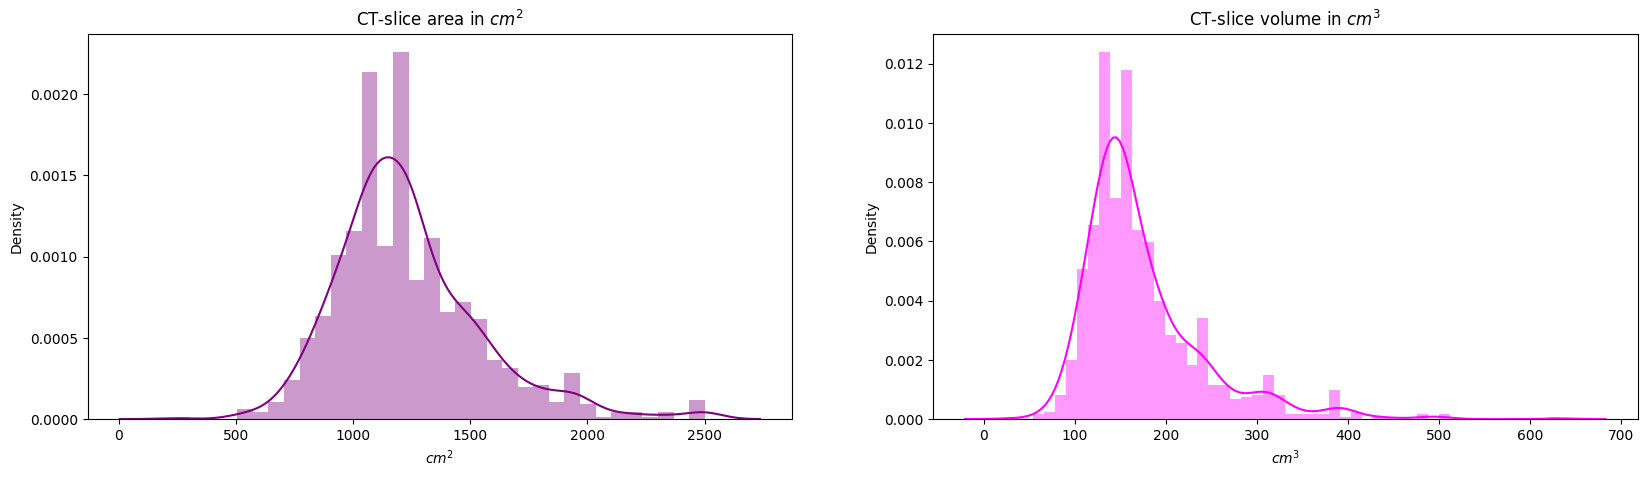

In [25]:
scan_properties["r_distance"] = scan_properties.pixelspacing_r * scan_properties.rows
scan_properties["c_distance"] = scan_properties.pixelspacing_c * scan_properties["columns"]
scan_properties["area_cm2"] = 0.1* scan_properties["r_distance"] * 0.1*scan_properties["c_distance"]
scan_properties["slice_volume_cm3"] = 0.1*scan_properties.slice_thickness * scan_properties.area_cm2

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(scan_properties.area_cm2, ax=ax[0], color="purple")
sns.distplot(scan_properties.slice_volume_cm3, ax=ax[1], color="magenta")
ax[0].set_title("CT-slice area in $cm^{2}$")
ax[1].set_title("CT-slice volume in $cm^{3}$")
ax[0].set_xlabel("$cm^{2}$")
ax[1].set_xlabel("$cm^{3}$");

📌 We have some images with extreme large sliche areas and volumes! I think it's time to do some EDA regarding these features!

### CT-scan slice area and volume - EDA

In [29]:
max_path = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.max()].patient_pth.values[0]
min_path = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.min()].patient_pth.values[0]

min_scans = load_scans(min_path)
min_hu_scans = transform_to_hu(min_scans)

max_scans = load_scans(max_path)
max_hu_scans = transform_to_hu(max_scans)

background_water_hu_scans = max_hu_scans.copy()

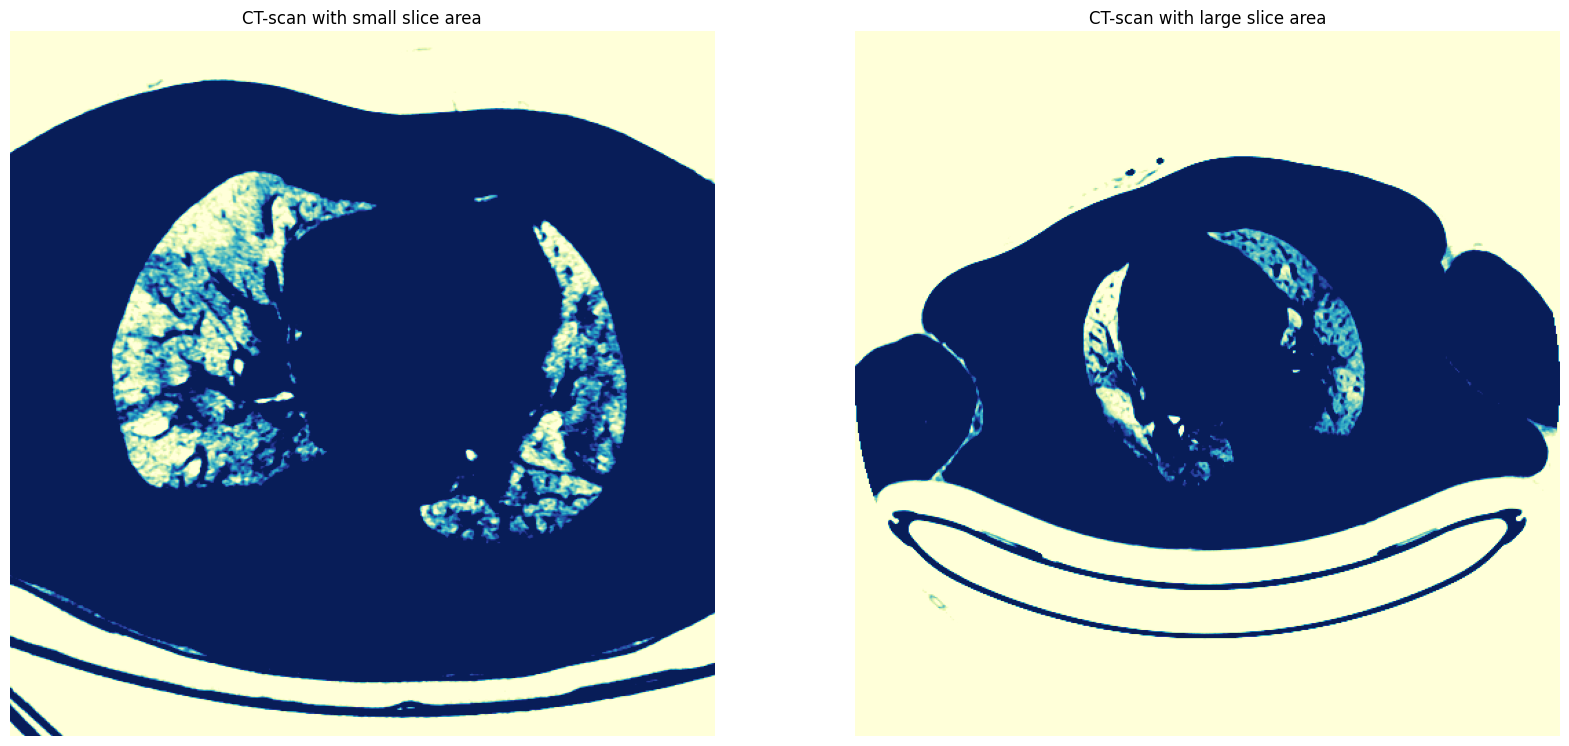

In [30]:
def set_manual_window(hu_image, custom_center, custom_width):
    w_image = hu_image.copy()
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    w_image[w_image < min_value] = min_value
    w_image[w_image > max_value] = max_value
    return w_image

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(min_hu_scans[int(len(min_hu_scans) / 2)], -700, 255), cmap="YlGnBu")
ax[1].imshow(set_manual_window(max_hu_scans[int(len(max_hu_scans) / 2)], -700, 255), cmap="YlGnBu")
ax[0].set_title("CT-scan with small slice area")
ax[1].set_title("CT-scan with large slice area");
for n in range(2):
    ax[n].axis("off")

Text(0.5, 0, 'HU values')

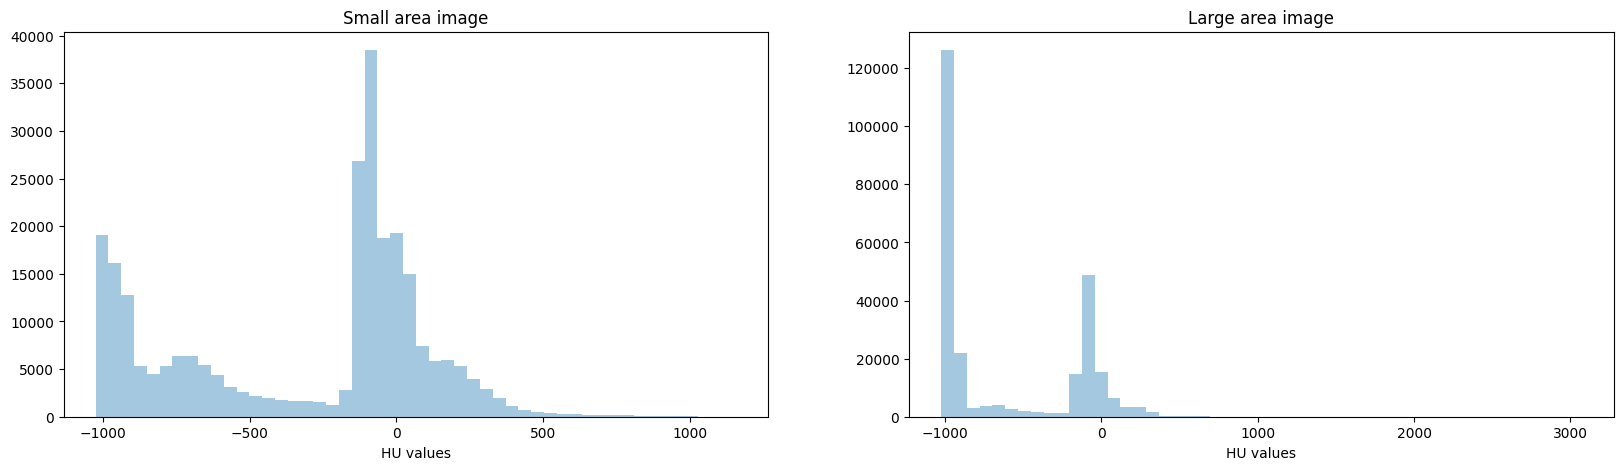

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(max_hu_scans[int(len(max_hu_scans) / 2)].flatten(), kde=False, ax=ax[1])
ax[1].set_title("Large area image")

sns.distplot(min_hu_scans[int(len(min_hu_scans) / 2)].flatten(), kde=False, ax=ax[0])
ax[0].set_title("Small area image")

ax[0].set_xlabel("HU values")
ax[1].set_xlabel("HU values")

📌 **Important Insights**

Taking a look at one slice of a scan with smallest and largest slice area, we can see that the large one has a lot of useless region covered. We could crop it.

Strange... in the second image with the large area the outside region of the scanner tube is not set to the value of air but rather to some value in the middle of the range -1000 to 1000.

### Smallest and largest CT-slice volume

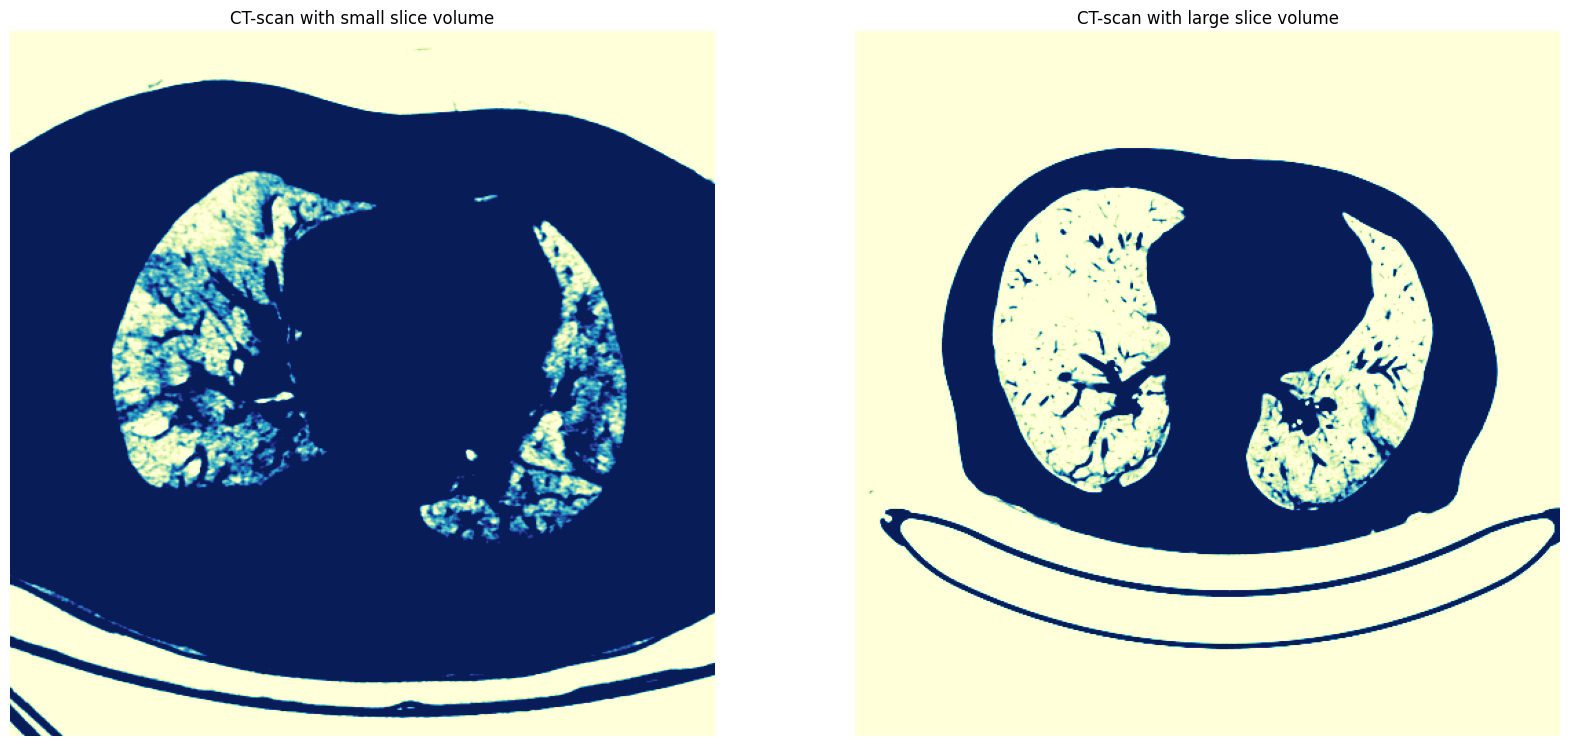

In [34]:
max_path = scan_properties[
    scan_properties.slice_volume_cm3 == scan_properties.slice_volume_cm3.max()].patient_pth.values[0]
min_path = scan_properties[
    scan_properties.slice_volume_cm3 == scan_properties.slice_volume_cm3.min()].patient_pth.values[0]

min_scans = load_scans(min_path)
min_hu_scans = transform_to_hu(min_scans)

max_scans = load_scans(max_path)
max_hu_scans = transform_to_hu(max_scans)


fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(min_hu_scans[int(len(min_hu_scans) / 2)], -700, 255), cmap="YlGnBu")
ax[1].imshow(set_manual_window(max_hu_scans[int(len(max_hu_scans) / 2)], -700, 255), cmap="YlGnBu")
ax[0].set_title("CT-scan with small slice volume")
ax[1].set_title("CT-scan with large slice volume");
for n in range(2):
    ax[n].axis("off")

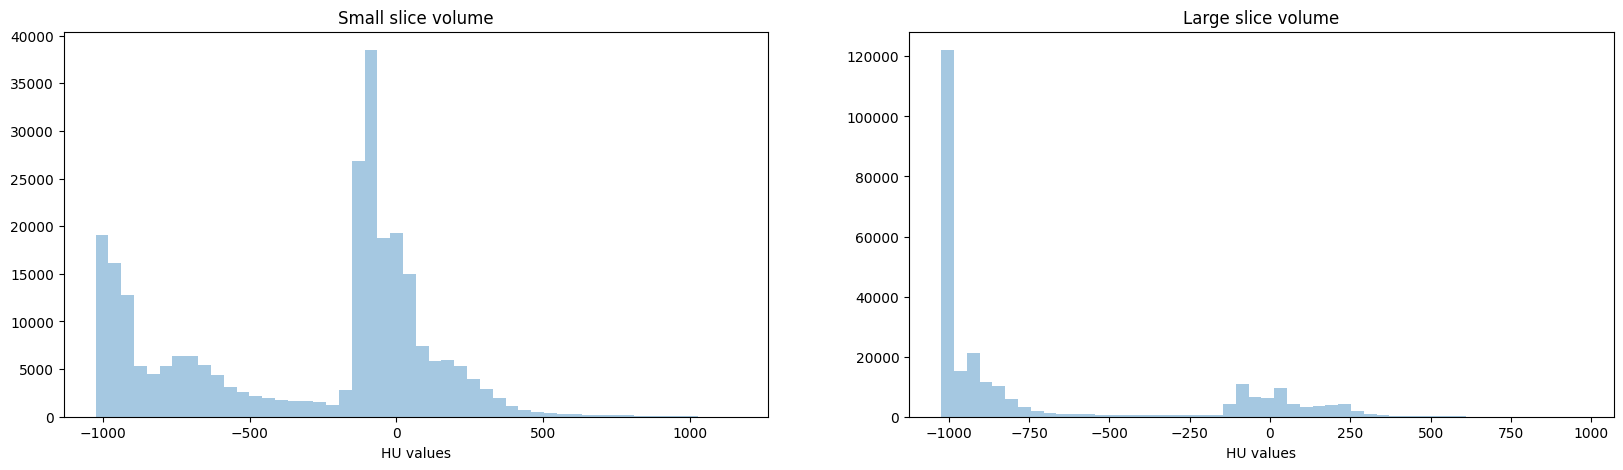

In [37]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(max_hu_scans[int(len(max_hu_scans) / 2)].flatten(), kde=False, ax=ax[1])
ax[1].set_title("Large slice volume")
sns.distplot(min_hu_scans[int(len(min_hu_scans) / 2)].flatten(), kde=False, ax=ax[0])
ax[0].set_title("Small slice volume")
ax[0].set_xlabel("HU values")
ax[1].set_xlabel("HU values");


### 3D Reconstruction of lungs

In [40]:
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=700, color="navy"):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2, 1, 0)

    # Updated function name
    verts, faces, _, _ = measure.marching_cubes(p, level=threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.2)
    mesh.set_facecolor(color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

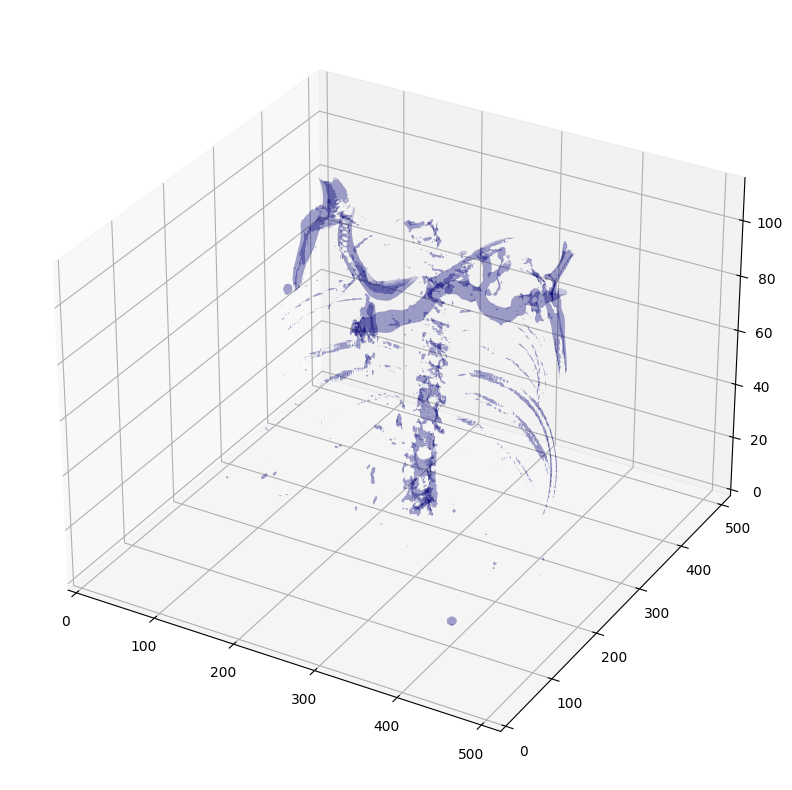

In [41]:
plot_3d(max_hu_scans)

### Lung Segmentation

In [77]:
def segment_lung_mask(image):
    segmented = np.zeros(image.shape)   
    
    for n in range(image.shape[0]):
        binary_image = np.array(image[n] > -320, dtype=np.int8)+1
        labels = measure.label(binary_image)
        
        bad_labels = np.unique([labels[0,:], labels[-1,:], labels[:,0], labels[:,-1]])
        for bad_label in bad_labels:
            binary_image[labels == bad_label] = 2
    
        #We have a lot of remaining small signals outside of the lungs that need to be removed. 
        #In our competition closing is superior to fill_lungs 
        selem = disk(2)
        binary_image = opening(binary_image, selem)
    
        binary_image -= 1 #Make the image actual binary
        binary_image = 1-binary_image # Invert it, lungs are now 1
        
        segmented[n] = binary_image.copy() * image[n]
    
    return segmented

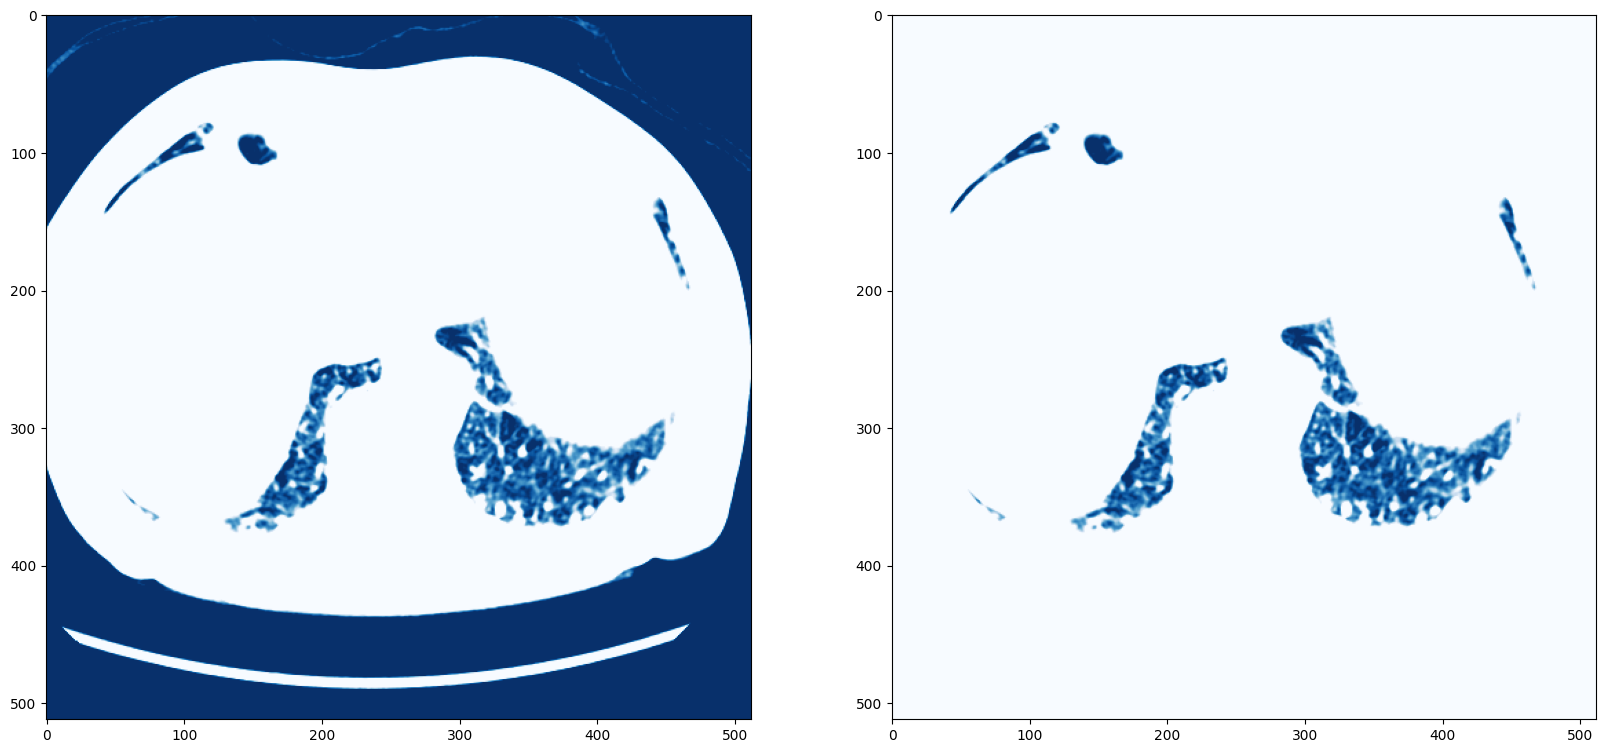

In [78]:
segmented = segment_lung_mask(np.array([hu_scans[20]]))

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(hu_scans[20], -700, 255), cmap="Blues_r")
ax[1].imshow(set_manual_window(segmented[0], -700, 255), cmap="Blues_r");

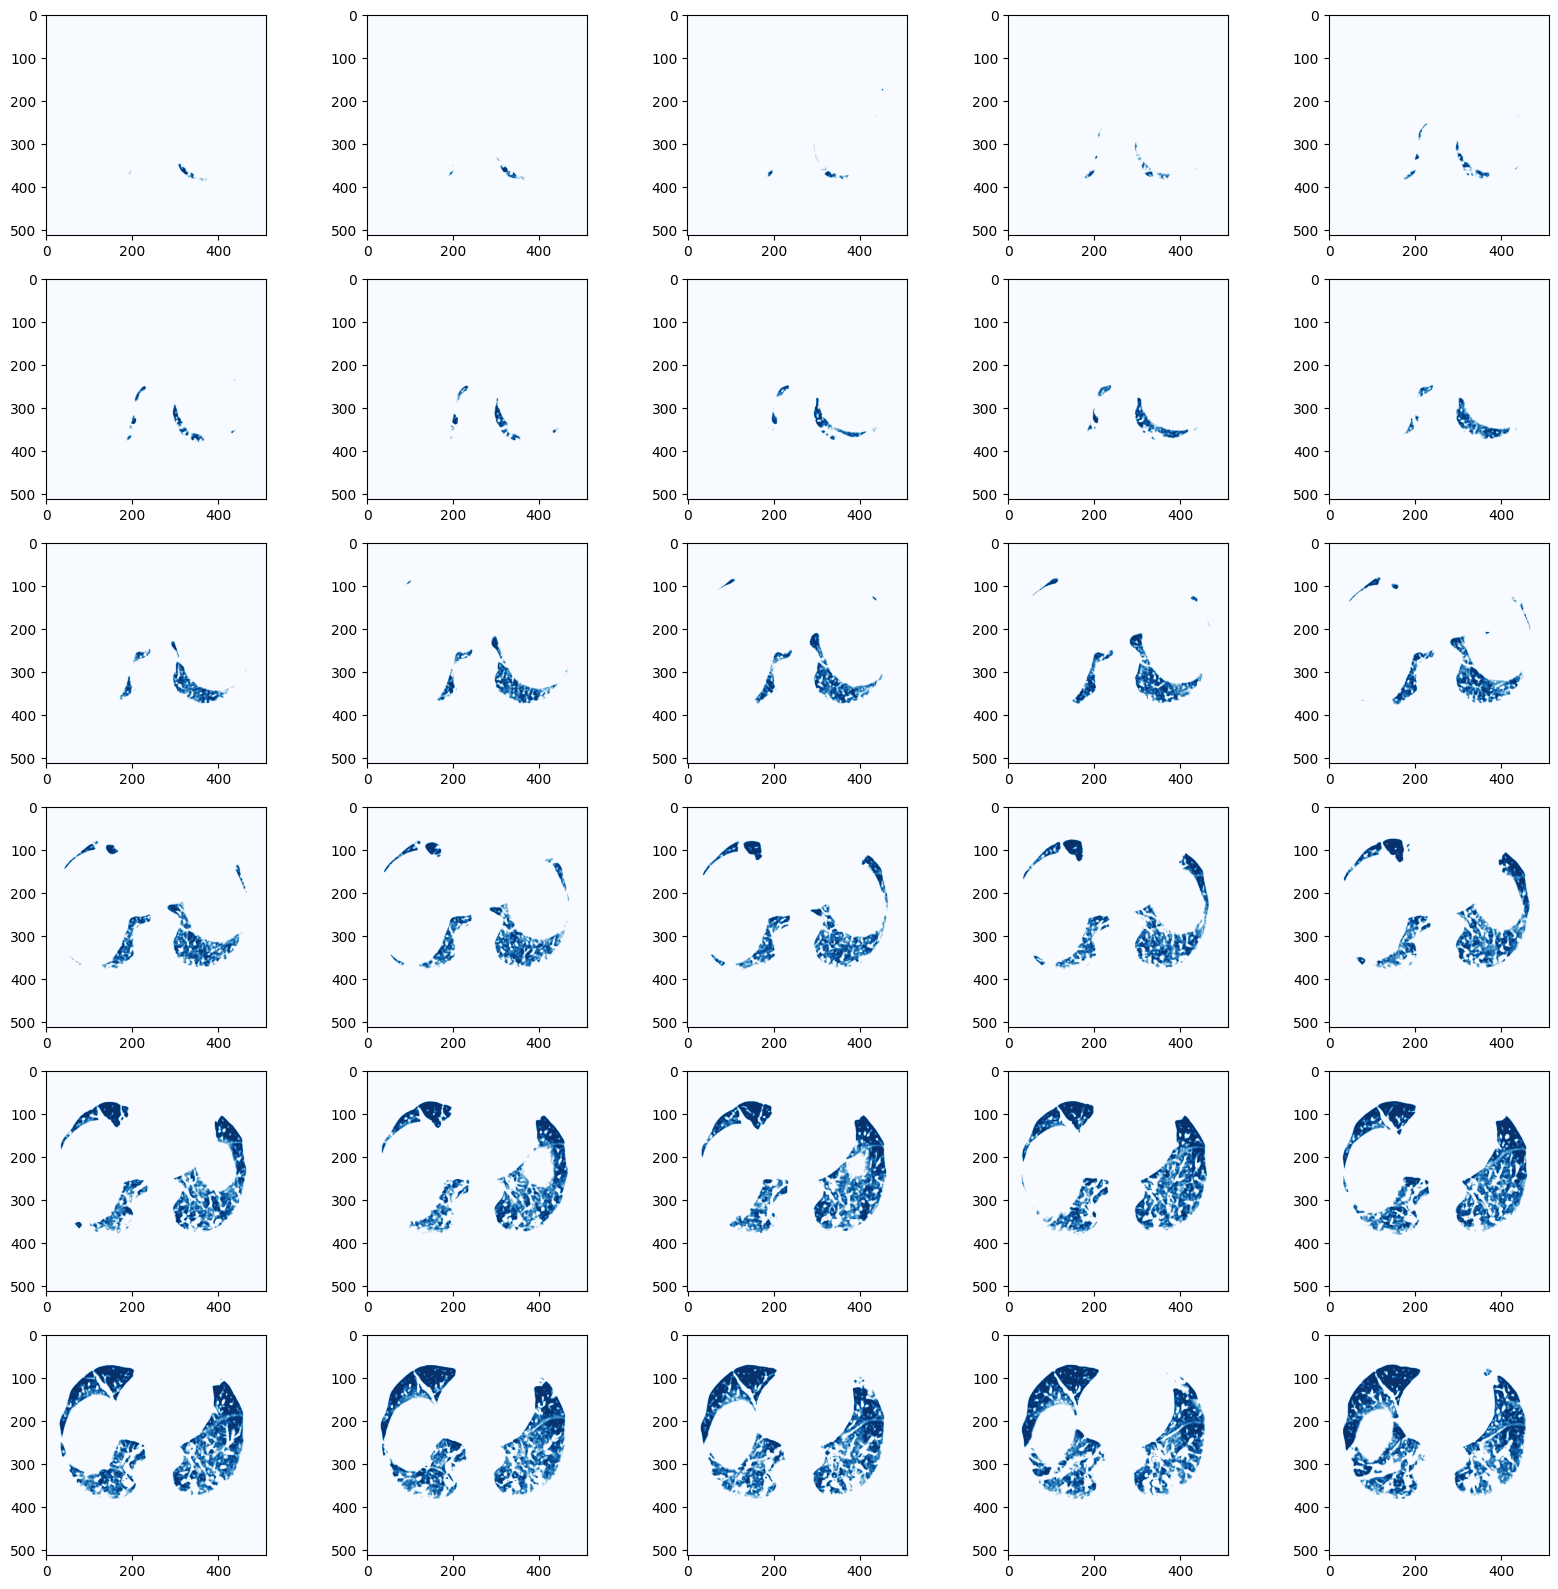

In [45]:
segmented_lungs = segment_lung_mask(hu_scans)
fig, ax = plt.subplots(6,5, figsize=(20,20))
for n in range(6):
    for m in range(5):
        ax[n,m].imshow(set_manual_window(segmented_lungs[(n+1)*5+m], -700, 255), cmap="Blues_r")

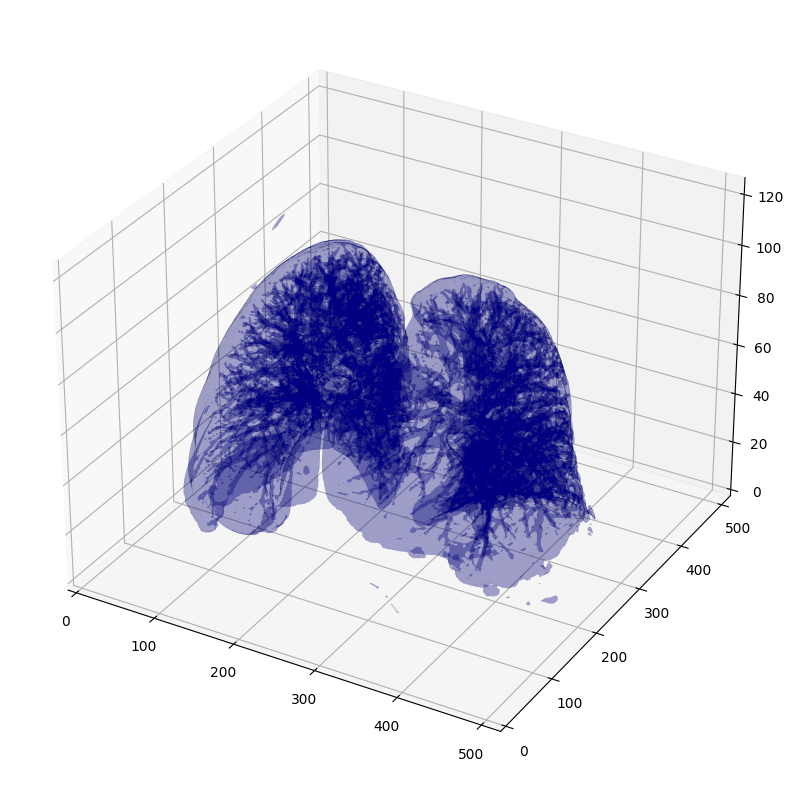

In [46]:
plot_3d(segmented_lungs, threshold=-600)

### Another approach (Following Guido's)

In [74]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask_guido(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [75]:
segmented_lungs_guido = segment_lung_mask_guido(hu_scans, False)
segmented_lungs_fill_guido = segment_lung_mask_guido(hu_scans, True)

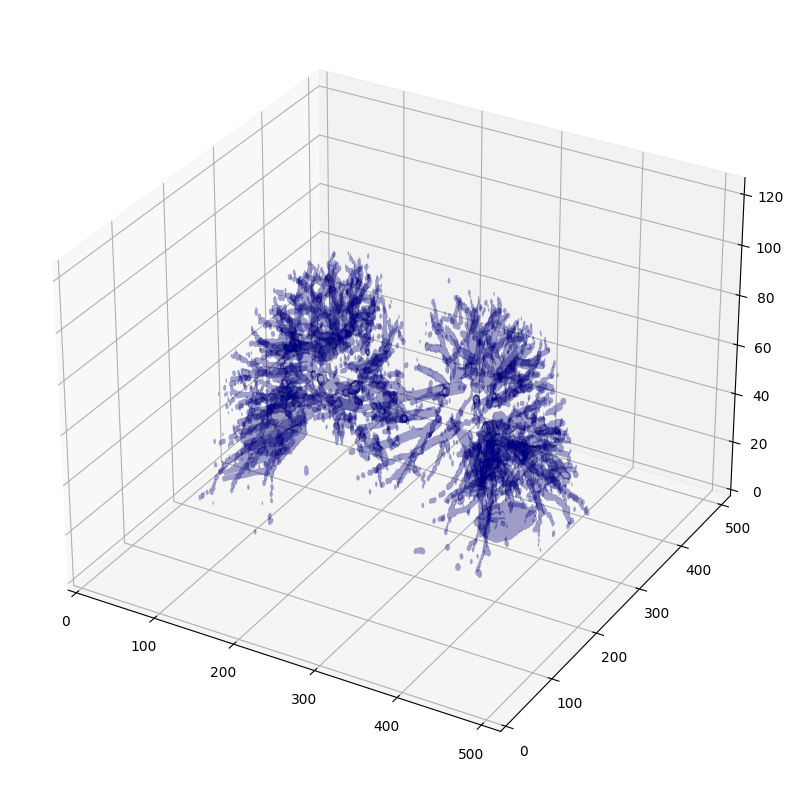

In [76]:
plot_3d(segmented_lungs_fill_guido - segmented_lungs_guido, 0)

In [81]:
twohundred_patient = train.dcm_path.values[200]
all_twohundred_patient_scans = load_scans(twohundred_patient)
twohundred_patient_pixels = transform_to_hu(all_twohundred_patient_scans)

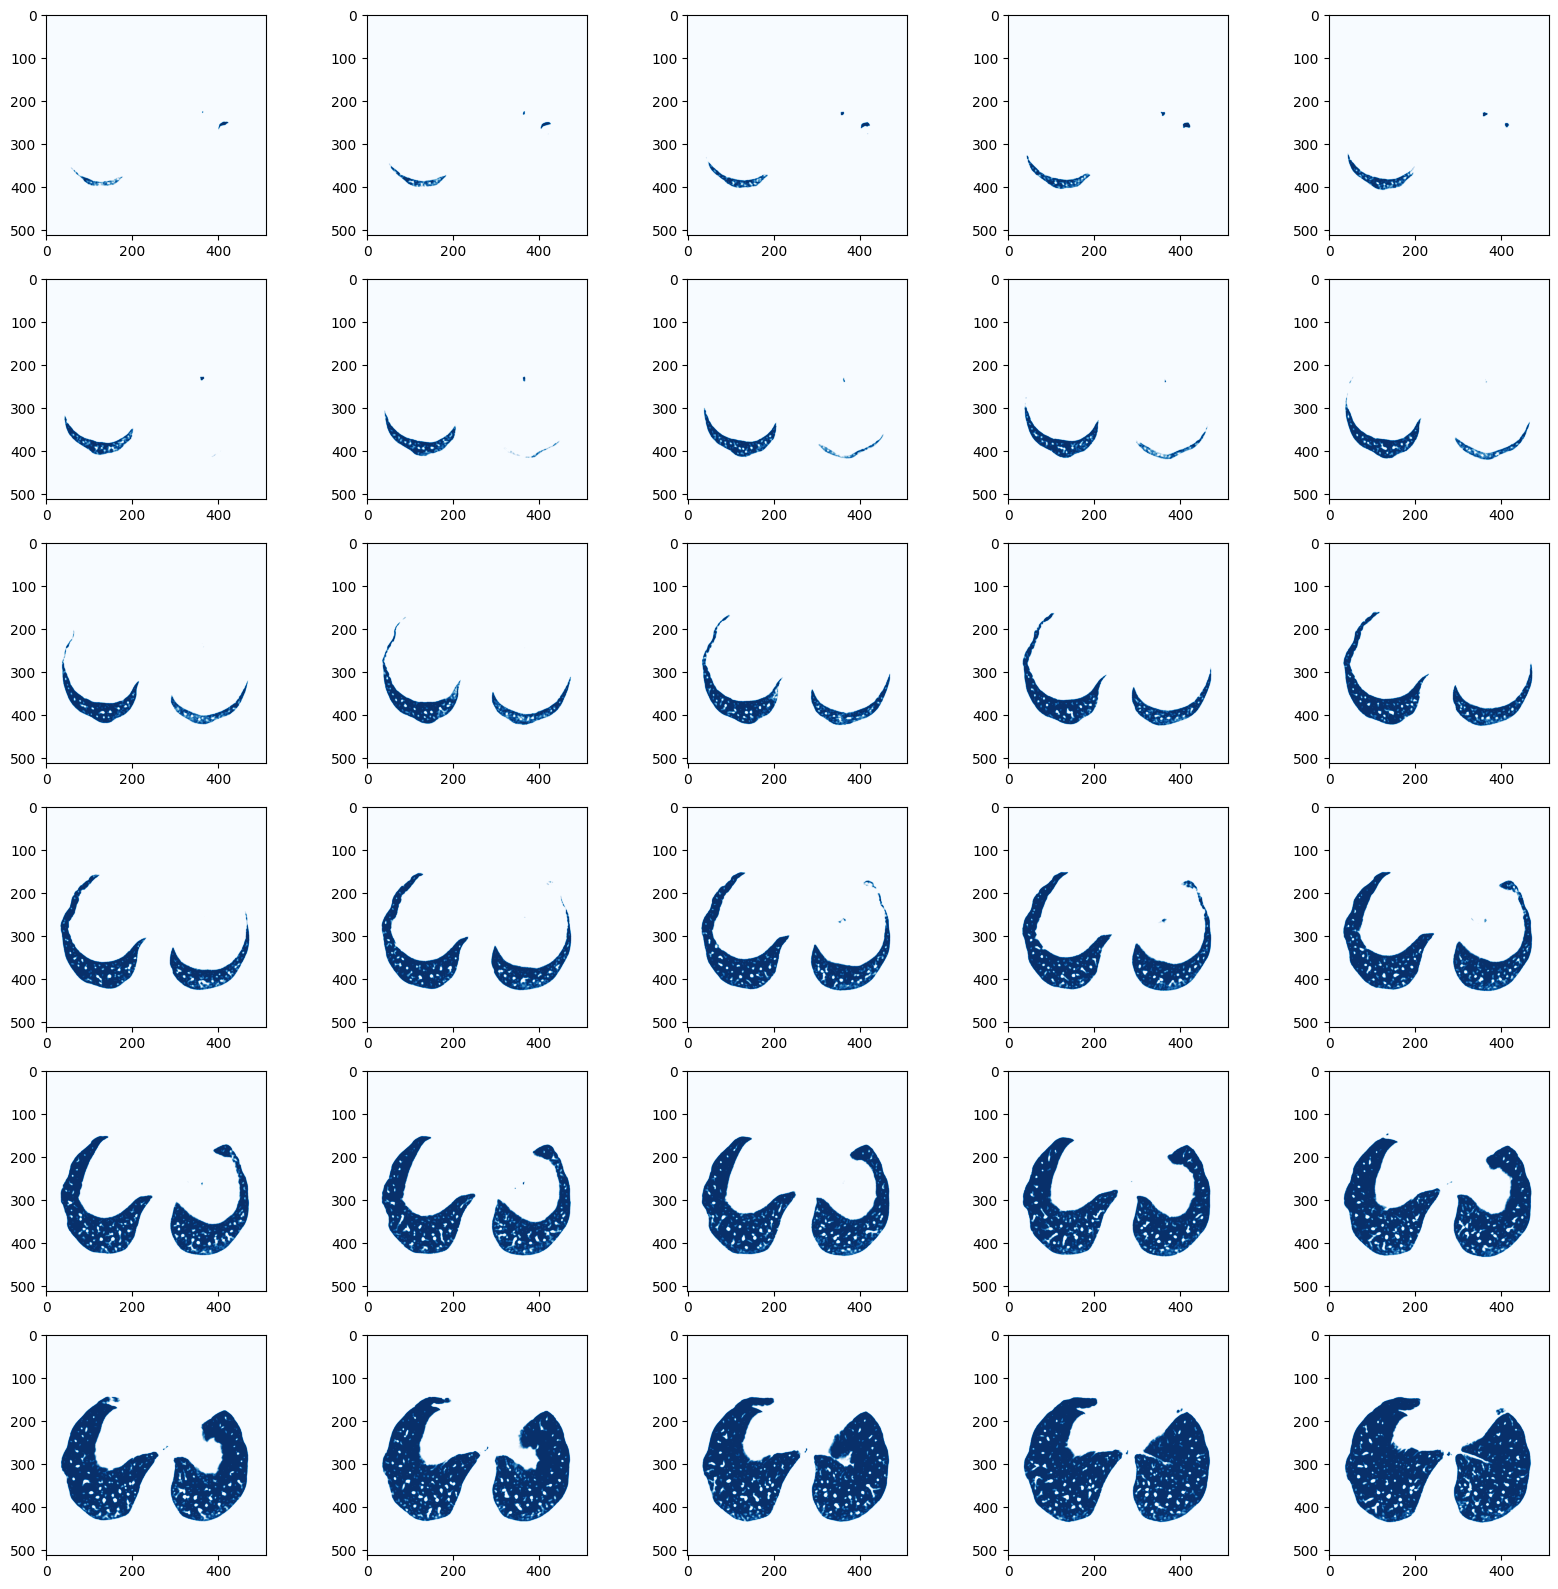

In [85]:
segmented_lungs_patienttwohundred = segment_lung_mask(twohundred_patient_pixels)
fig, ax = plt.subplots(6,5, figsize=(20,20))
for n in range(6):
    for m in range(5):
        ax[n,m].imshow(set_manual_window(segmented_lungs[(n+1)*5+m], -700, 255), cmap="Blues_r")